# Parsing logs with Apache Spark

In this notebook we will parse a log file and answer the following questions:

1. Sessionize the web log by IP. Sessionize = aggregrate all page hits by visitor/IP during a fixed time window.
    https://en.wikipedia.org/wiki/Session_(web_analytics)

2. Determine the average session time

3. Determine unique URL visits per session. To clarify, count a hit to a unique URL only once per session.

4. Find the most engaged users, ie the IPs with the longest session times

In order to run all results below with tests, run weblog_stats.py

### Setup

This notebook can be run on an AWS cluster, or it can be run locally in Spark's standalone mode.  To setup Spark in standalone mode, follow the directions here:
http://spark.apache.org/docs/latest/spark-standalone.html#spark-standalone-mode

Once Spark is running (and the install directory added to your PATH), you can start a Jupyter notebook with the following command:

PYSPARK_DRIVER_PYTHON=ipython PYSPARK_DRIVER_PYTHON_OPTS="notebook" ./pyspark

### Loading the Data

Since I'm not running Spark on a Hadoop cluster, we can skip over loading the data into HDFS.  I will just load the data directly.

In [1]:
print sc  #Just making sure I've got a spark context

The fields in the file are as follows.  They are space delimited, unless the spaces are contained in quotes.

'timestamp','elb','client_port','backend_port','request_processing_time','backend_processing_time',
'response_processing_time','elb_status_code','backend_status_code','received_bytes','sent_bytes',
'request','user_agent','ssl_cipher','ssl_protocol'

First thing I'm going to do is get the data into a Pandas dataframe, as this will make my life easier.

In [2]:
import re
from datetime import datetime

def custom_split(line):
    #fortunately, I don't care about anything past the request field, which makes the regex fairly simple
    line_parts = re.findall(r"[\w\"\-\/\.:\?\=\&]+", line) #split on both space and "
    timestamp = datetime.strptime(line_parts[0], '%Y-%m-%dT%H:%M:%S.%fZ')
    elb = line_parts[1]
    client_port = line_parts[2].split(':')[0] #using ip address as an identifier, so I feel that it makes sense to ditch the port number
    backend_port = line_parts[3]
    request_processing_time = float(line_parts[4])
    backend_processing_time = float(line_parts[5])
    response_processing_time = float(line_parts[6])
    elb_status_code = int(line_parts[7])
    backend_status_code = int(line_parts[8])
    received_bytes = int(line_parts[9])
    sent_bytes = int(line_parts[10])
    request_type = line_parts[11]
    request_url = line_parts[12]
    
    return timestamp,elb,client_port,backend_port,request_processing_time,backend_processing_time,response_processing_time,elb_status_code,backend_status_code,received_bytes,sent_bytes,request_type,request_url

print "Sanity check:"
print custom_split('2015-07-22T09:00:28.019143Z marketpalce-shop 123.242.248.130:54635 10.0.6.158:80 0.000022 0.026109 0.00002 200 200 0 699 "GET https://paytm.com:443/shop/authresponse?code=f2405b05-e2ee-4b0d-8f6a-9fed0fcfe2e0&state=null HTTP/1.1" "Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/43.0.2357.130 Safari/537.36" ECDHE-RSA-AES128-GCM-SHA256 TLSv1.2')

dataRdd = sc.textFile('data/2015_07_22_mktplace_shop_web_log_sample.log')
#splitRdd = dataRdd.map(lambda line: re.findall(r"[\w\"]+", line))
splitRdd = dataRdd.map(custom_split)

Sanity check:
(datetime.datetime(2015, 7, 22, 9, 0, 28, 19143), 'marketpalce-shop', '123.242.248.130', '10.0.6.158:80', 2.2e-05, 0.026109, 2e-05, 200, 200, 0, 699, '"GET', 'https://paytm.com:443/shop/authresponse?code=f2405b05-e2ee-4b0d-8f6a-9fed0fcfe2e0&state=null')


In [ ]:
columns = ['timestamp','elb','client_port','backend_port','request_processing_time','backend_processing_time',
           'response_processing_time','elb_status_code','backend_status_code','received_bytes','sent_bytes',
           'request_type', 'request_url']

df = splitRdd.toDF().toPandas()
df.columns = columns

In [47]:
import pandas as pd

df_by_ip = df.groupby('client_port')

#create session ids by comparing each timestamp to the next timestamp is series and seeing if greater than our alloted time have passed
df['session_id'] = df_by_ip['timestamp'].apply(lambda x: (x - x.shift(1) > pd.Timedelta("15 min")).cumsum())

df.head()

,timestamp,elb,client_port,backend_port,request_processing_time,backend_processing_time,response_processing_time,elb_status_code,backend_status_code,received_bytes,sent_bytes,request_type,request_url,session_id
0,2015-07-22 09:00:28.019143,marketpalce-shop,123.242.248.130,10.0.6.158:80,0.000022,0.026109,0.000020,200,200,0,699,"""GET",https://paytm.com:443/shop/authresponse?code=f...,0
1,2015-07-22 09:00:27.894580,marketpalce-shop,203.91.211.44,10.0.4.150:80,0.000024,0.153340,0.000026,200,200,0,1497,"""GET",https://paytm.com:443/shop/wallet/txnhistory?p...,0
2,2015-07-22 09:00:27.885745,marketpalce-shop,1.39.32.179,10.0.4.244:80,0.000024,0.164958,0.000017,200,200,0,157,"""GET",https://paytm.com:443/shop/wallet/txnhistory?p...,0
3,2015-07-22 09:00:28.048369,marketpalce-shop,180.179.213.94,10.0.6.108:80,0.000020,0.002333,0.000021,200,200,0,35734,"""GET",https://paytm.com:443/shop/p/micromax-yu-yurek...,0
4,2015-07-22 09:00:28.036251,marketpalce-shop,120.59.192.208,10.0.4.217:80,0.000024,0.015091,0.000016,200,200,68,640,"""POST",https://paytm.com:443/papi/v1/expresscart/verify,0


### Summary Statistics

Now that it's all in a dataframe and sessionized, grabbing stats is straightforward using the typical Pythonic datascience pipeline.

In [49]:
import numpy as np

def sessionDuration(x):
    duration = max(x) - min(x)
    if duration < pd.Timedelta("15 min"):
        return pd.Timedelta("15 min")
    else:
        return duration

#assuming minimum session time of 15 minutes
session_times = df.groupby(['client_port', 'session_id'])['timestamp'].apply(sessionDuration)
print "average session time if we call a single call a 15 minute session " + str(np.mean(session_times))

#assuming minimum session time of 0 minutes
session_times = df.groupby(['client_port','session_id'])['timestamp'].apply(lambda x: max(x) - min(x))
print "average session time if we call a single call a 0 minute session " + str(np.mean(session_times))


average session time if we call a single call a 15 minute session 0 days 00:40:13.839997
average session time if we call a single call a 0 minute session 0 days 00:27:38.654991


In [52]:
df['session_urls'] = df.groupby(['client_port','session_id'])['request_url'].transform('nunique')

print "our dataframe now contains a column that shows how many unique urls were hit in each session"
print "example: user with ip address 123.242.248.130 on there first session viewed " + str(df[df['client_port'] == '123.242.248.130']['session_urls'][0]) + " urls" 
print "average number of urls hit per session : " + str( np.mean(df['session_urls']))

our dataframe now contains a column that shows how many unique urls were hit in each session
example: user with ip address 123.242.248.130 on there first session viewed 26 urls
average number of urls hit per session : 454.51559085


In [54]:
print "user with the longest session " + str(session_times.idxmax())
print "longest session length " + str(session_times.max())

user with the longest session (u'119.81.61.166', 2)
longest session length 0 days 15:05:21.267258


### Somethings not right here

The longest session was 15 hours long?  My human intuition is tingling; that doesn't seem realistic.  Lets do another little poke around, as it seems like I haven't given a correct answer to the last question : "Who is the most engaged user?"

Lets take a look at that user, and also the distribution of our session times.

                      timestamp               elb    client_port  \
439  2015-07-22 09:00:29.145692  marketpalce-shop  119.81.61.166   
447  2015-07-22 09:00:29.162188  marketpalce-shop  119.81.61.166   
734  2015-07-22 09:00:29.841644  marketpalce-shop  119.81.61.166   
901  2015-07-22 09:00:30.177694  marketpalce-shop  119.81.61.166   
1056 2015-07-22 09:00:30.546168  marketpalce-shop  119.81.61.166   

       backend_port  request_processing_time  backend_processing_time  \
439   10.0.4.225:80                 0.000015                 0.019887   
447   10.0.4.217:80                 0.000017                 0.014434   
734   10.0.4.227:80                 0.000018                 0.007397   
901   10.0.4.176:80                 0.000018                 0.007236   
1056  10.0.4.150:80                 0.000021                 0.009572   

      response_processing_time  elb_status_code  backend_status_code  \
439                   0.000020              200                  200   
447     

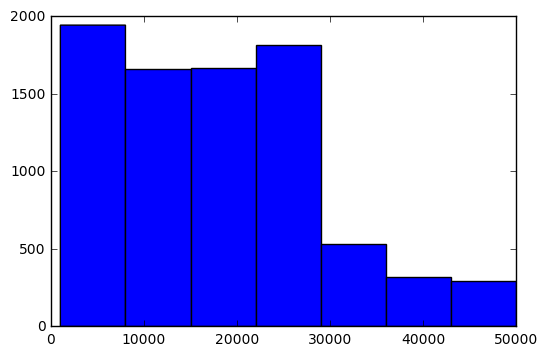

In [57]:
print df[df['client_port'] == session_times.idxmax()[0]].head()

%matplotlib inline
plotable_session_times = session_times.apply(lambda x: x.seconds)
plotable_session_times = plotable_session_times[plotable_session_times >1000] #most sessions are very quick, we want to view the higher ranges, so knock off the low session times for readability
import matplotlib.pyplot as plt
plt.hist(plotable_session_times, bins=range(1000,max(plotable_session_times),7000))
plt.show()

It looks like that user is just hammering 'promosearch' urls mulitple times per second.  I do believe he is some kind of bot or spider, and therefor not the most engaged user.

There is a sharp dropoff around 30000 seconds mark, which is around 8 hours.  People using the site all day at work maybe?  The best way to sort the bots from the users would be a 'honeypot' page that only spiders would ever browse.  For the lack of one of those, I will just filter by what seems like a reasonable threshold of browsing for a person.  If we consider anybody past the 8 hour session mark to be more likely a robot than a person, our most engaged user would be:

In [64]:
human_session_times = plotable_session_times[plotable_session_times < 30000]
print "ip address of user with longest session time that does not exceed 30000 seconds : "  + str(human_session_times.idxmax()[0])
print "duration of max length session that doesn not exceed 30000 seconds : " + str(human_session_times.max() / 60.0) + " minutes"

df[df['client_port'] == human_session_times.idxmax()[0]].head()

ip address of user with longest session time that does not exceed 30000 seconds : 155.136.184.7
duration of max length session that doesn not exceed 30000 seconds : 489.6 minutes


,timestamp,elb,client_port,backend_port,request_processing_time,backend_processing_time,response_processing_time,elb_status_code,backend_status_code,received_bytes,sent_bytes,request_type,request_url,session_id,session_urls
34459,2015-07-22 09:01:55.637204,marketpalce-shop,155.136.184.7,10.0.4.227:80,0.000023,0.006250,0.000018,200,200,0,14194,"""GET",https://paytm.com:443/shop/p/pantaloons-blue-c...,0,5
35239,2015-07-22 09:01:58.108068,marketpalce-shop,155.136.184.7,10.0.6.158:80,0.000026,0.033645,0.000021,200,200,0,751,"""GET",https://paytm.com:443/shop/cart?channel=web&ve...,0,5
35667,2015-07-22 09:01:59.265102,marketpalce-shop,155.136.184.7,10.0.4.227:80,0.000036,0.006161,0.000022,304,304,0,0,"""GET",https://paytm.com:443/papi/nps/merchantrating?...,0,5
35773,2015-07-22 09:01:59.599113,marketpalce-shop,155.136.184.7,10.0.6.178:80,0.000021,0.005349,0.000020,200,200,0,413,"""GET",https://paytm.com:443/papi/v1/promosearch/prod...,0,5
35824,2015-07-22 09:01:59.756876,marketpalce-shop,155.136.184.7,10.0.4.244:80,0.000021,0.008505,0.000015,200,200,0,72,"""GET",https://paytm.com:443/papi/rr/products/1422278...,0,5


Now we have geniunely found a very engaged user who used the site for 8 hours straight while shopping for pantaloons.